In [1]:
data_dir = "/home/daneel/workspace/simulations"
import os
simulation_dirs = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
from tqdm.notebook import tqdm
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt

### Load all simulation complexes

In [2]:
complexes = {}

for dir in tqdm(simulation_dirs):
    topol_file = [f for f in os.listdir(os.path.join(data_dir, dir)) if f.endswith('.tpr')][0]
    traj_file = [f for f in os.listdir(os.path.join(data_dir, dir)) if f.endswith('.xtc')][0]
    complexes[dir] = mda.Universe(os.path.join(data_dir, dir, topol_file),
                                  os.path.join(data_dir, dir, traj_file))

  0%|          | 0/12 [00:00<?, ?it/s]

### Calculate all RMSD values and load in a dataframe

  0%|          | 0/12 [00:00<?, ?it/s]

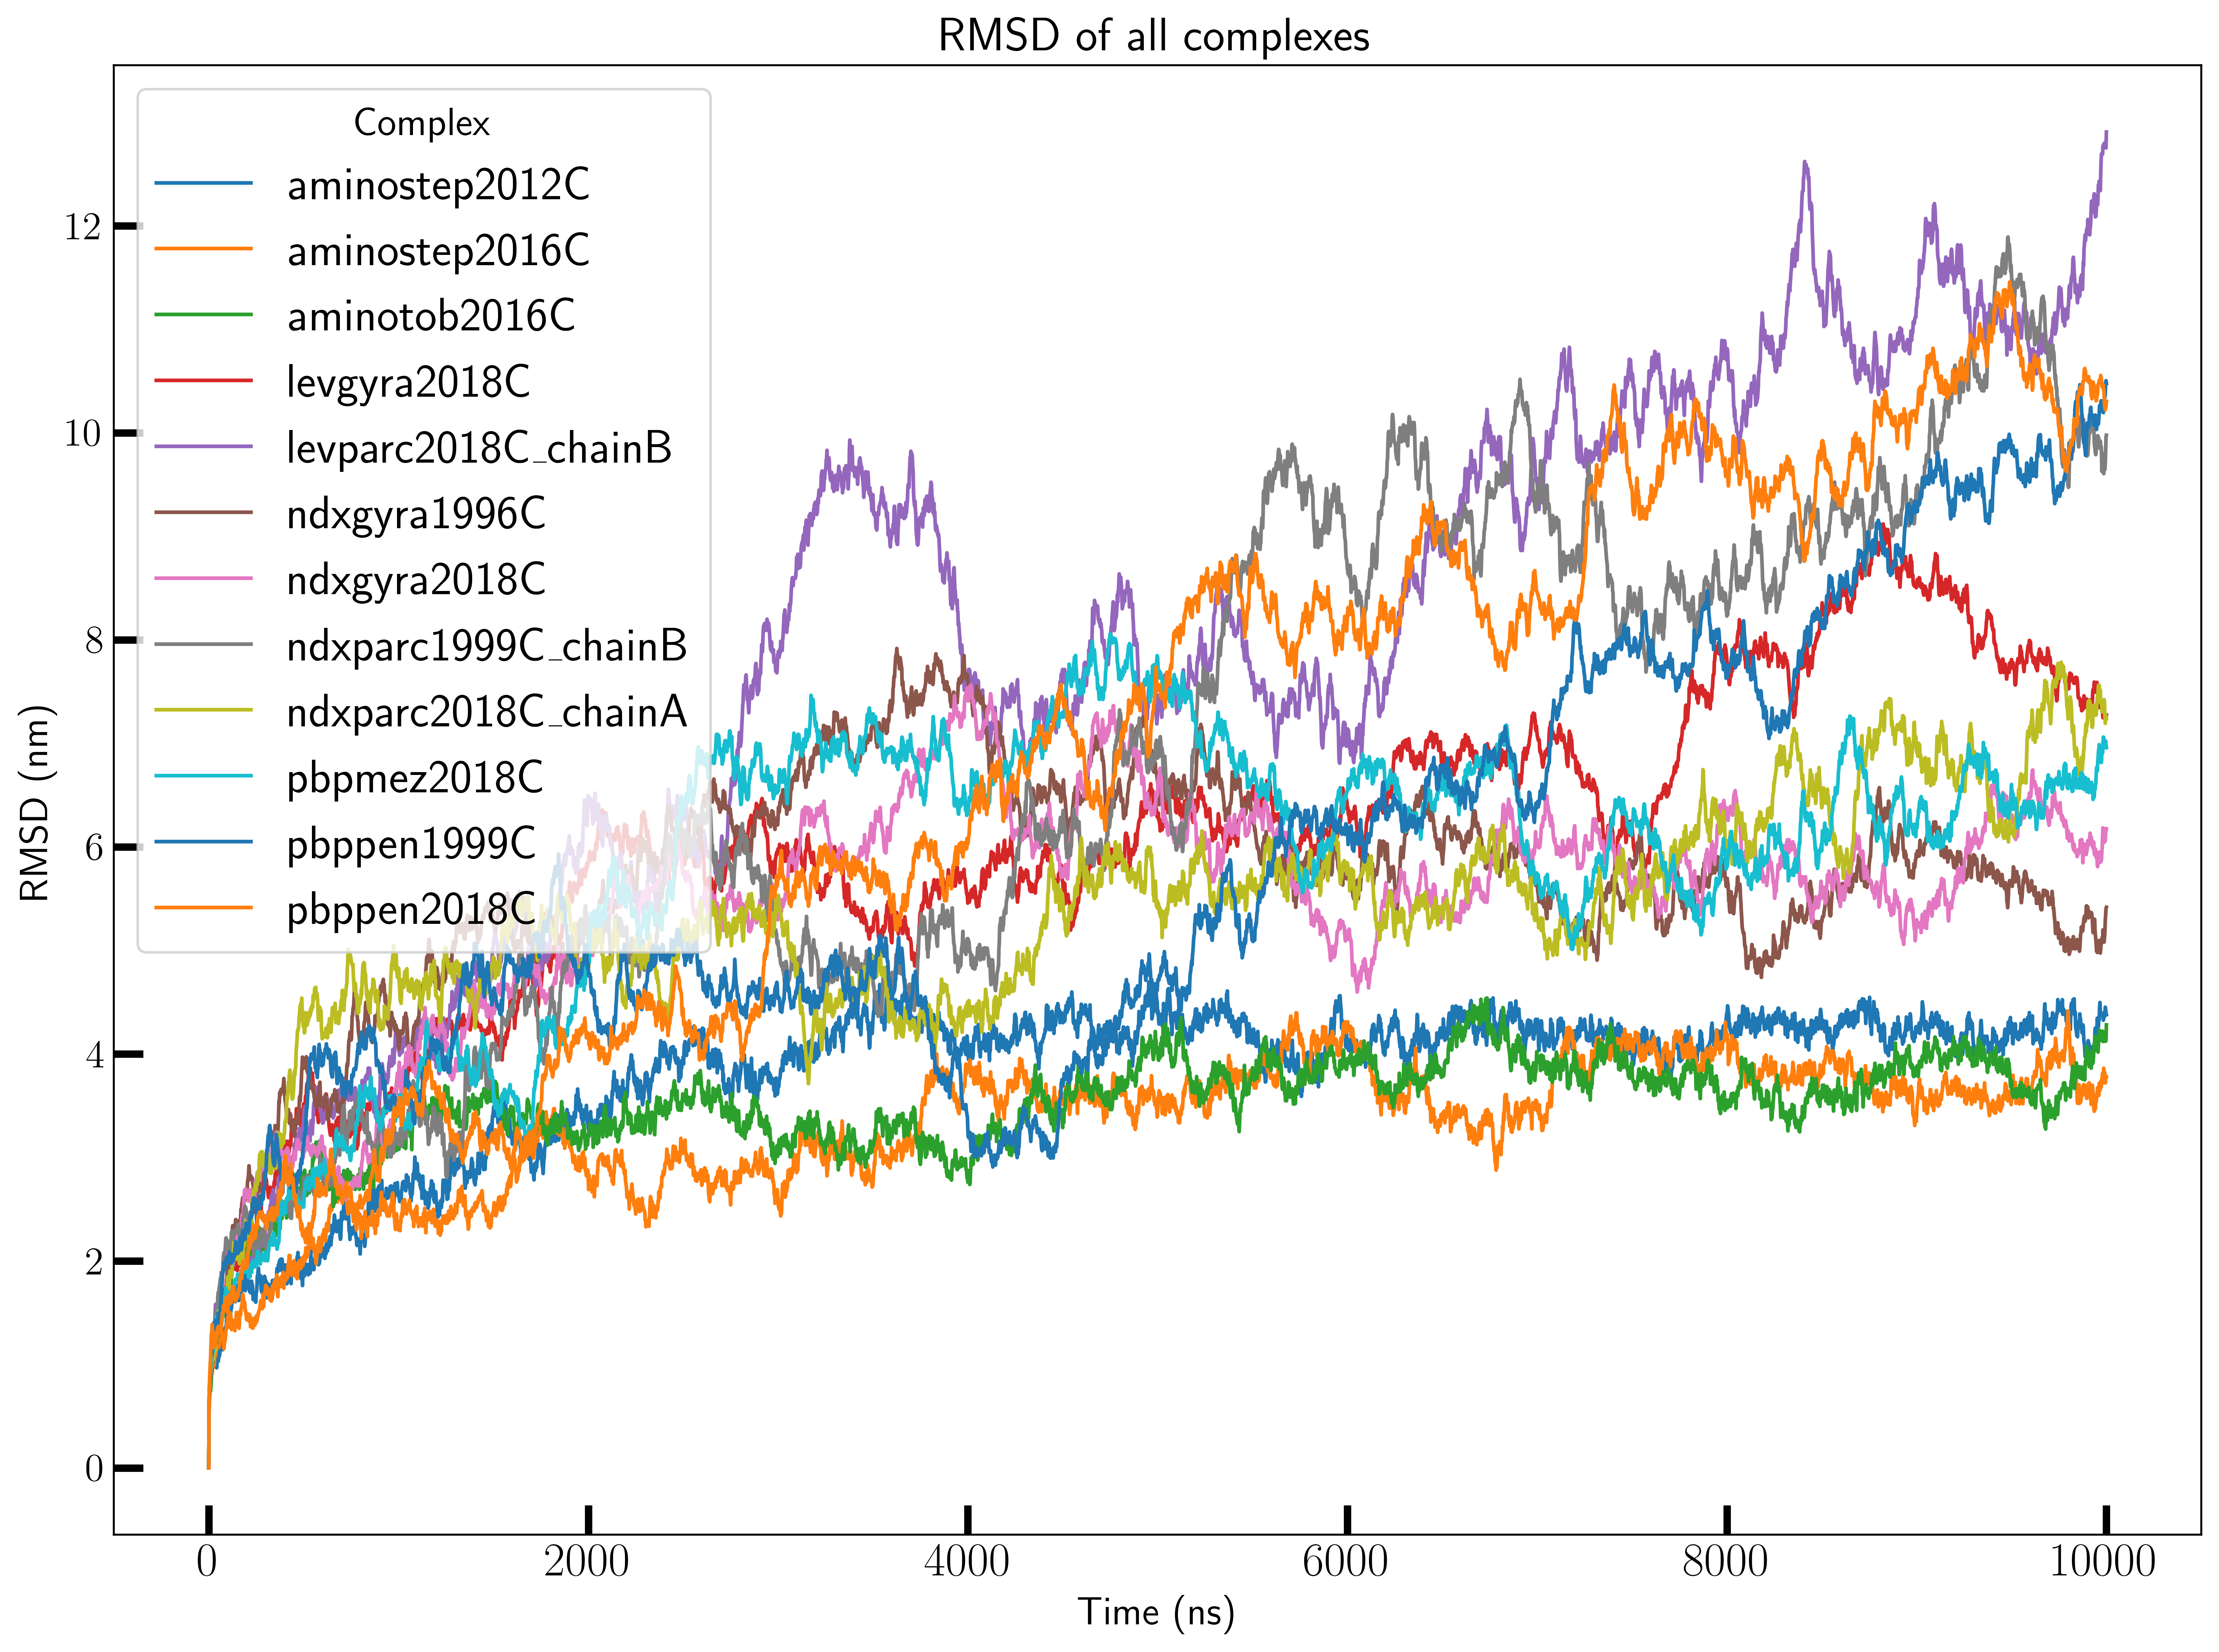

In [3]:
import pandas as pd
from MDAnalysis.analysis import rms
# Build the DataFrame directly by running the RMSD analysis for each complex
rmsd_df = None
for complexname, universe in tqdm(complexes.items()):
    R_local = rms.RMSD(universe, universe, select='backbone', ref_frame=0)
    R_local.run(verbose=False)
    times = R_local.results.rmsd[:, 1]
    rmsd = R_local.results.rmsd[:, 2]
    
    # For the first complex, initialize the DataFrame with the time column.
    if rmsd_df is None:
        rmsd_df = pd.DataFrame({'Time': times})
        
    # Add the RMSD values for the current complex to the DataFrame.
    rmsd_df[complexname] = rmsd

# Prepare and display the plot.
rmsd_df.set_index('Time', inplace=True)
rmsd_df.plot()
plt.xlabel('Time (ns)')
plt.ylabel('RMSD (nm)')
plt.title('RMSD of all complexes')
plt.legend(title='Complex')
plt.show()


### Calculate all RMSF and load in a dataframe

In [4]:
import pandas as pd
from MDAnalysis.analysis import rms
# Build the DataFrame directly by running the RMSD analysis for each complex
rmsf_dict = {}
for complexname, universe in tqdm(complexes.items()):
    c_alphas_c = universe.select_atoms('backbone and name CA')
    R_c = rms.RMSF(c_alphas_c).run(verbose=False)
    resids = c_alphas_c.resids
    rmsf = R_c.results.rmsf
    rmsf_dict[f'{complexname}_resid'] = resids
    rmsf_dict[f'{complexname}_rmsf'] = rmsf


  0%|          | 0/12 [00:00<?, ?it/s]

### Calculate all Radii of Gyration and load in a dataframe 

  0%|          | 0/12 [00:00<?, ?it/s]

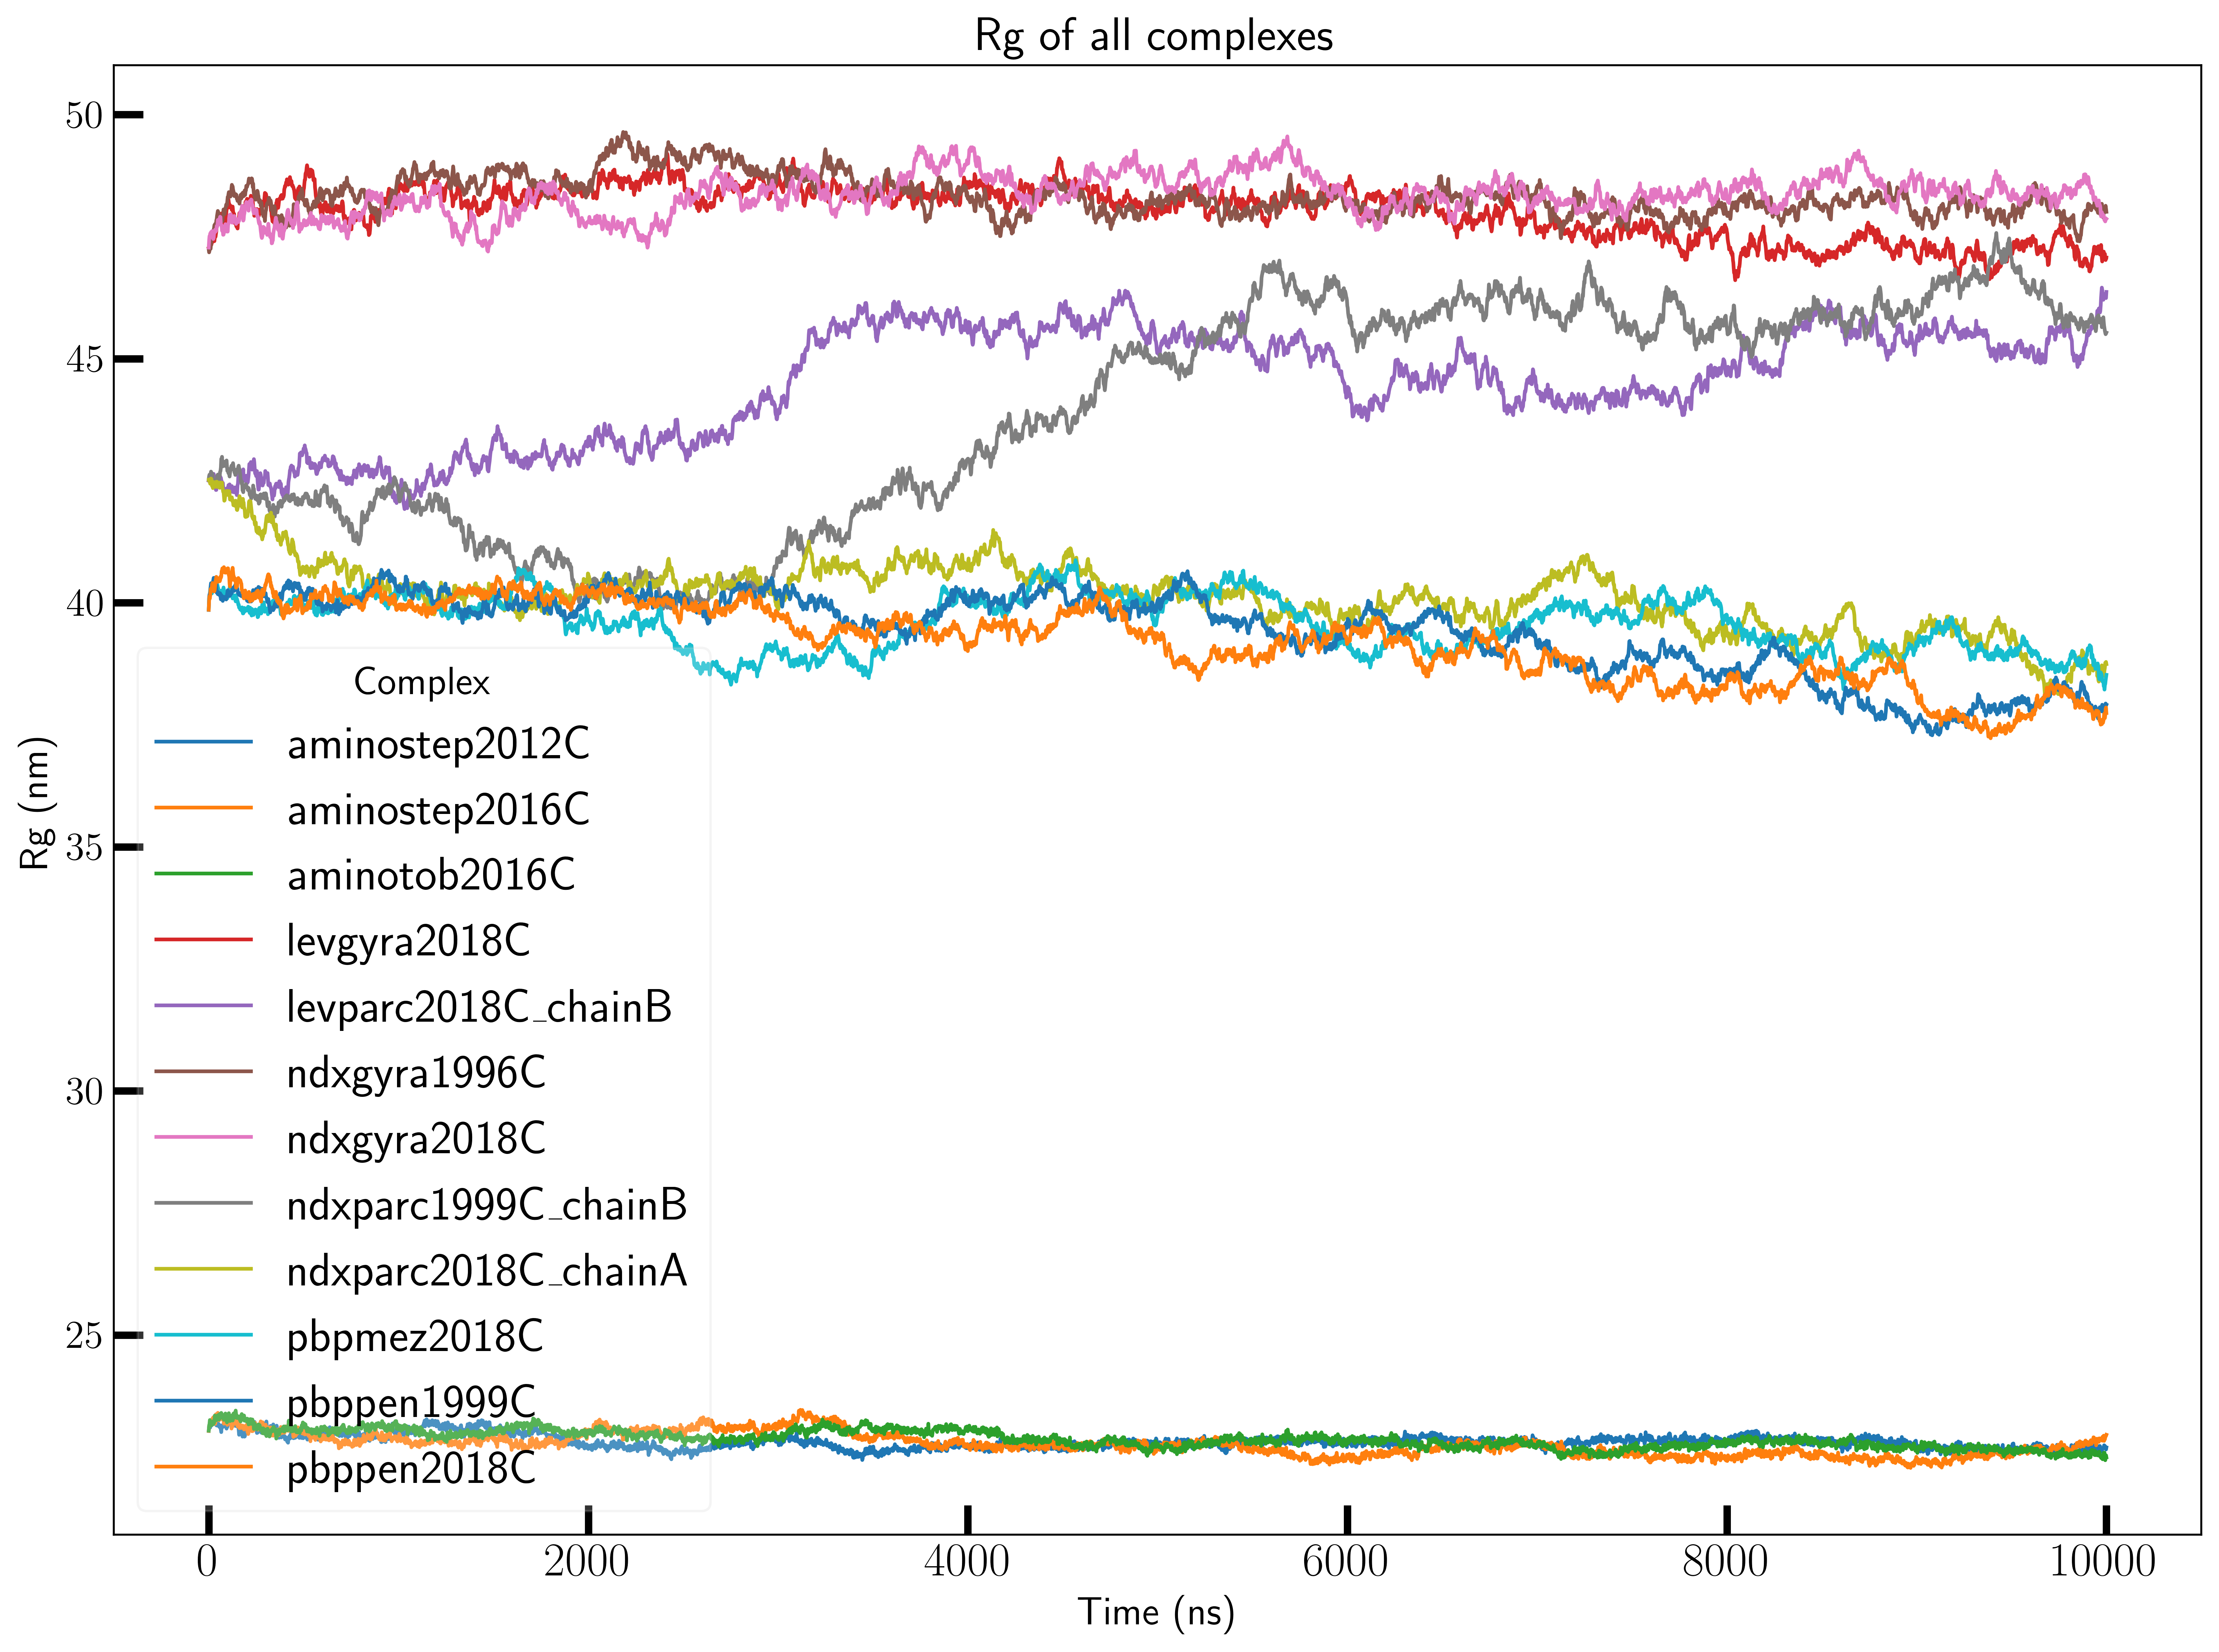

In [5]:
import pandas as pd
from MDAnalysis.analysis import rms
# Build the DataFrame directly by running the RMSD analysis for each complex
rg_df = None
for complexname, universe in tqdm(complexes.items()):
    group = universe.select_atoms('protein')
    times = []
    rg = []
    for ts in universe.trajectory:
        times.append(ts.time)
        rg.append(group.radius_of_gyration())
    # For the first complex, initialize the DataFrame with the time column.
    if rg_df is None:
        rg_df = pd.DataFrame({'Time': times})
        
    # Add the RMSD values for the current complex to the DataFrame.
    rg_df[complexname] = rg

# Prepare and display the plot.
rg_df.set_index('Time', inplace=True)
rg_df.plot()
plt.xlabel('Time (ns)')
plt.ylabel('Rg (nm)')
plt.title('Rg of all complexes')
lgd = plt.legend(title='Complex')
lgd.get_frame().set_alpha(0.2)
plt.show()

/usr/local/miniforge3/envs/biobb_wf_protein-complex_md_setup/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


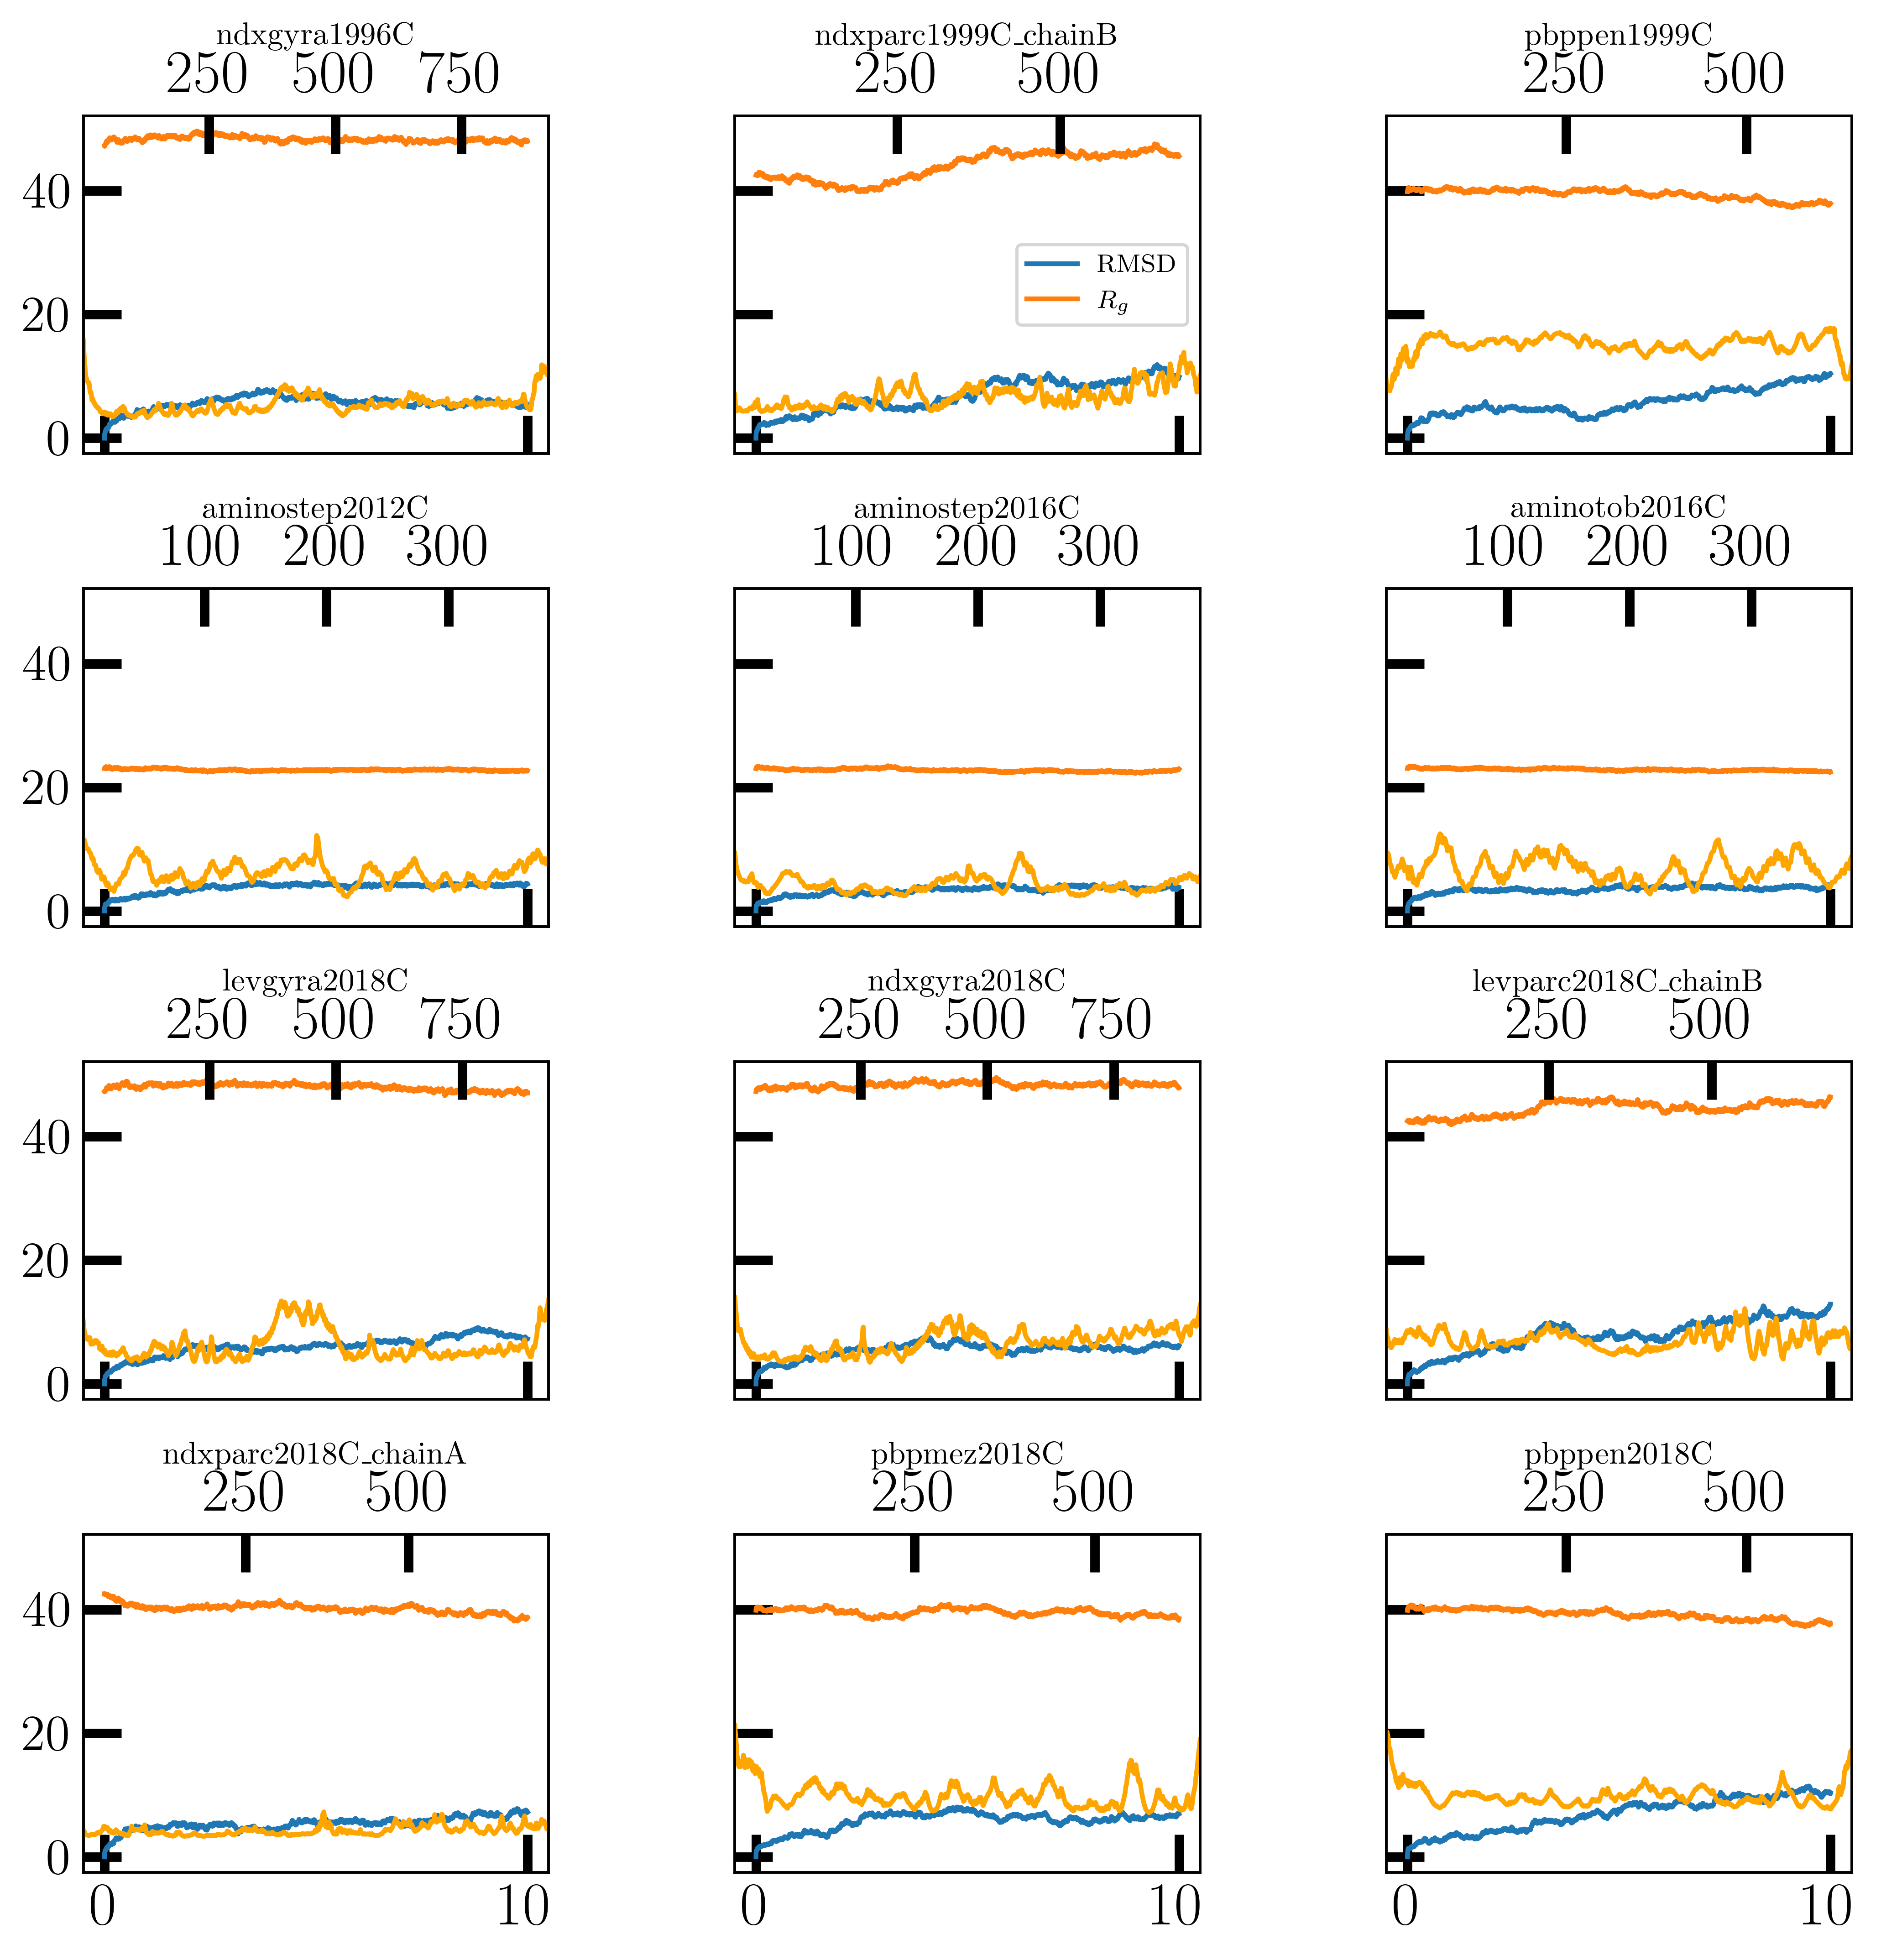

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

matplotlib.rcParams['axes.titlepad'] = 0
# Override the behavior of ax.axis('off') so that calls to turn off axes are ignored.
import matplotlib.axes as maxes
matplotlib.rcParams.update({'font.family': 'Times New Roman'})
_original_axis = maxes.Axes.axis

def new_axis(self, *args, **kwargs):
    if args and args[0] == 'off':
        return self  # Skip turning off the axes
    return _original_axis(self, *args, **kwargs)

maxes.Axes.axis = new_axis

# Define a 5x3 grid with custom spacing between subplots
fig, axs = plt.subplots(4, 3, figsize=(10, 10), gridspec_kw={'wspace': 0.4, 'hspace': 0.4}, sharex=True, sharey=True)

# Add subplots at specific grid positions
# For example, here we place one subplot per grid cell in a manner that mimics your layout.
ax_ndxgyra1996  = axs[0, 0]
ax_ndxparc1999  = axs[0,1]
ax_pbppen1999  = axs[0,2]
ax_aminostep2012  = axs[1,0]
ax_aminostep2016  = axs[1,1]
ax_aminotob2016  = axs[1,2]
ax_levgyra2018  = axs[2,0]
ax_ndxgyra2018  = axs[2,1]
ax_levparc2018  = axs[2,2]
ax_ndxparc2018  = axs[3,0]
ax_pbpmez2018  = axs[3,1]
ax_pbppen2018  = axs[3,2]
offset = 0.05  # adjust the offset as needed

l = "ndxgyra1996C"
ax_ndxgyra1996.set_title(l, fontsize=10)
ax_ndxgyra1996.plot(rmsd_df.index/1000, rmsd_df["ndxgyra1996C"], label="RMSD")
ax_ndxgyra1996.plot(rg_df.index/1000, rg_df["ndxgyra1996C"], label=r"$R_g$")

ax_top = ax_ndxgyra1996.twiny()
ax_top.set_xlim(rmsf_dict["ndxgyra1996C_resid"][0], rmsf_dict["ndxgyra1996C_resid"][-1])
ax_top.plot(rmsf_dict["ndxgyra1996C_resid"], rmsf_dict["ndxgyra1996C_rmsf"], label="RMSF", color='orange')

def add_plot(complexname, axis, rmsd_df, rg_df, top_dict, legend=False):
    axis.set_title(complexname, fontsize=10)
    axis.plot(rmsd_df.index/1000, rmsd_df[complexname], label="RMSD")
    axis.plot(rg_df.index/1000, rg_df[complexname], label=r"$R_g$")
    
    ax_top = axis.twiny()
    ax_top.set_xlim(top_dict[f"{complexname}_resid"][0], top_dict[f"{complexname}_resid"][-1])
    ax_top.plot(top_dict[f"{complexname}_resid"], top_dict[f"{complexname}_rmsf"], label="RMSF", color='orange')
    if legend:
        axis.legend(loc='best', fontsize=8, title_fontsize=8)



l = "ndxparc1999C_chainB"
add_plot(l,ax_ndxparc1999, rmsd_df, rg_df , rmsf_dict, legend=True)

l = "pbppen1999C"
add_plot(l,ax_pbppen1999, rmsd_df, rg_df , rmsf_dict)


l = "aminostep2012C"
add_plot(l,ax_aminostep2012, rmsd_df, rg_df , rmsf_dict)

l = "aminostep2016C"
add_plot(l,ax_aminostep2016, rmsd_df, rg_df , rmsf_dict)


l = "aminotob2016C"
add_plot(l,ax_aminotob2016, rmsd_df, rg_df , rmsf_dict)

l = "levgyra2018C"
add_plot(l,ax_levgyra2018, rmsd_df, rg_df , rmsf_dict)

l = "ndxgyra2018C"
add_plot(l,ax_ndxgyra2018, rmsd_df, rg_df , rmsf_dict)

l = "levparc2018C_chainB"
add_plot(l,ax_levparc2018, rmsd_df, rg_df , rmsf_dict)

l = "ndxparc2018C_chainA"
add_plot(l,ax_ndxparc2018, rmsd_df, rg_df , rmsf_dict)

l = "pbpmez2018C"
add_plot(l,ax_pbpmez2018, rmsd_df, rg_df , rmsf_dict)

l = "pbppen2018C"
add_plot(l,ax_pbppen2018, rmsd_df, rg_df , rmsf_dict)

# Set an overall title for the whole figure
#fig.suptitle('B-Lactam Groups with PBP2 and Aminoglycoside Group Interactions', fontsize=16)




# Display the plot
plt.show()


/usr/local/miniforge3/envs/biobb_wf_protein-complex_md_setup/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


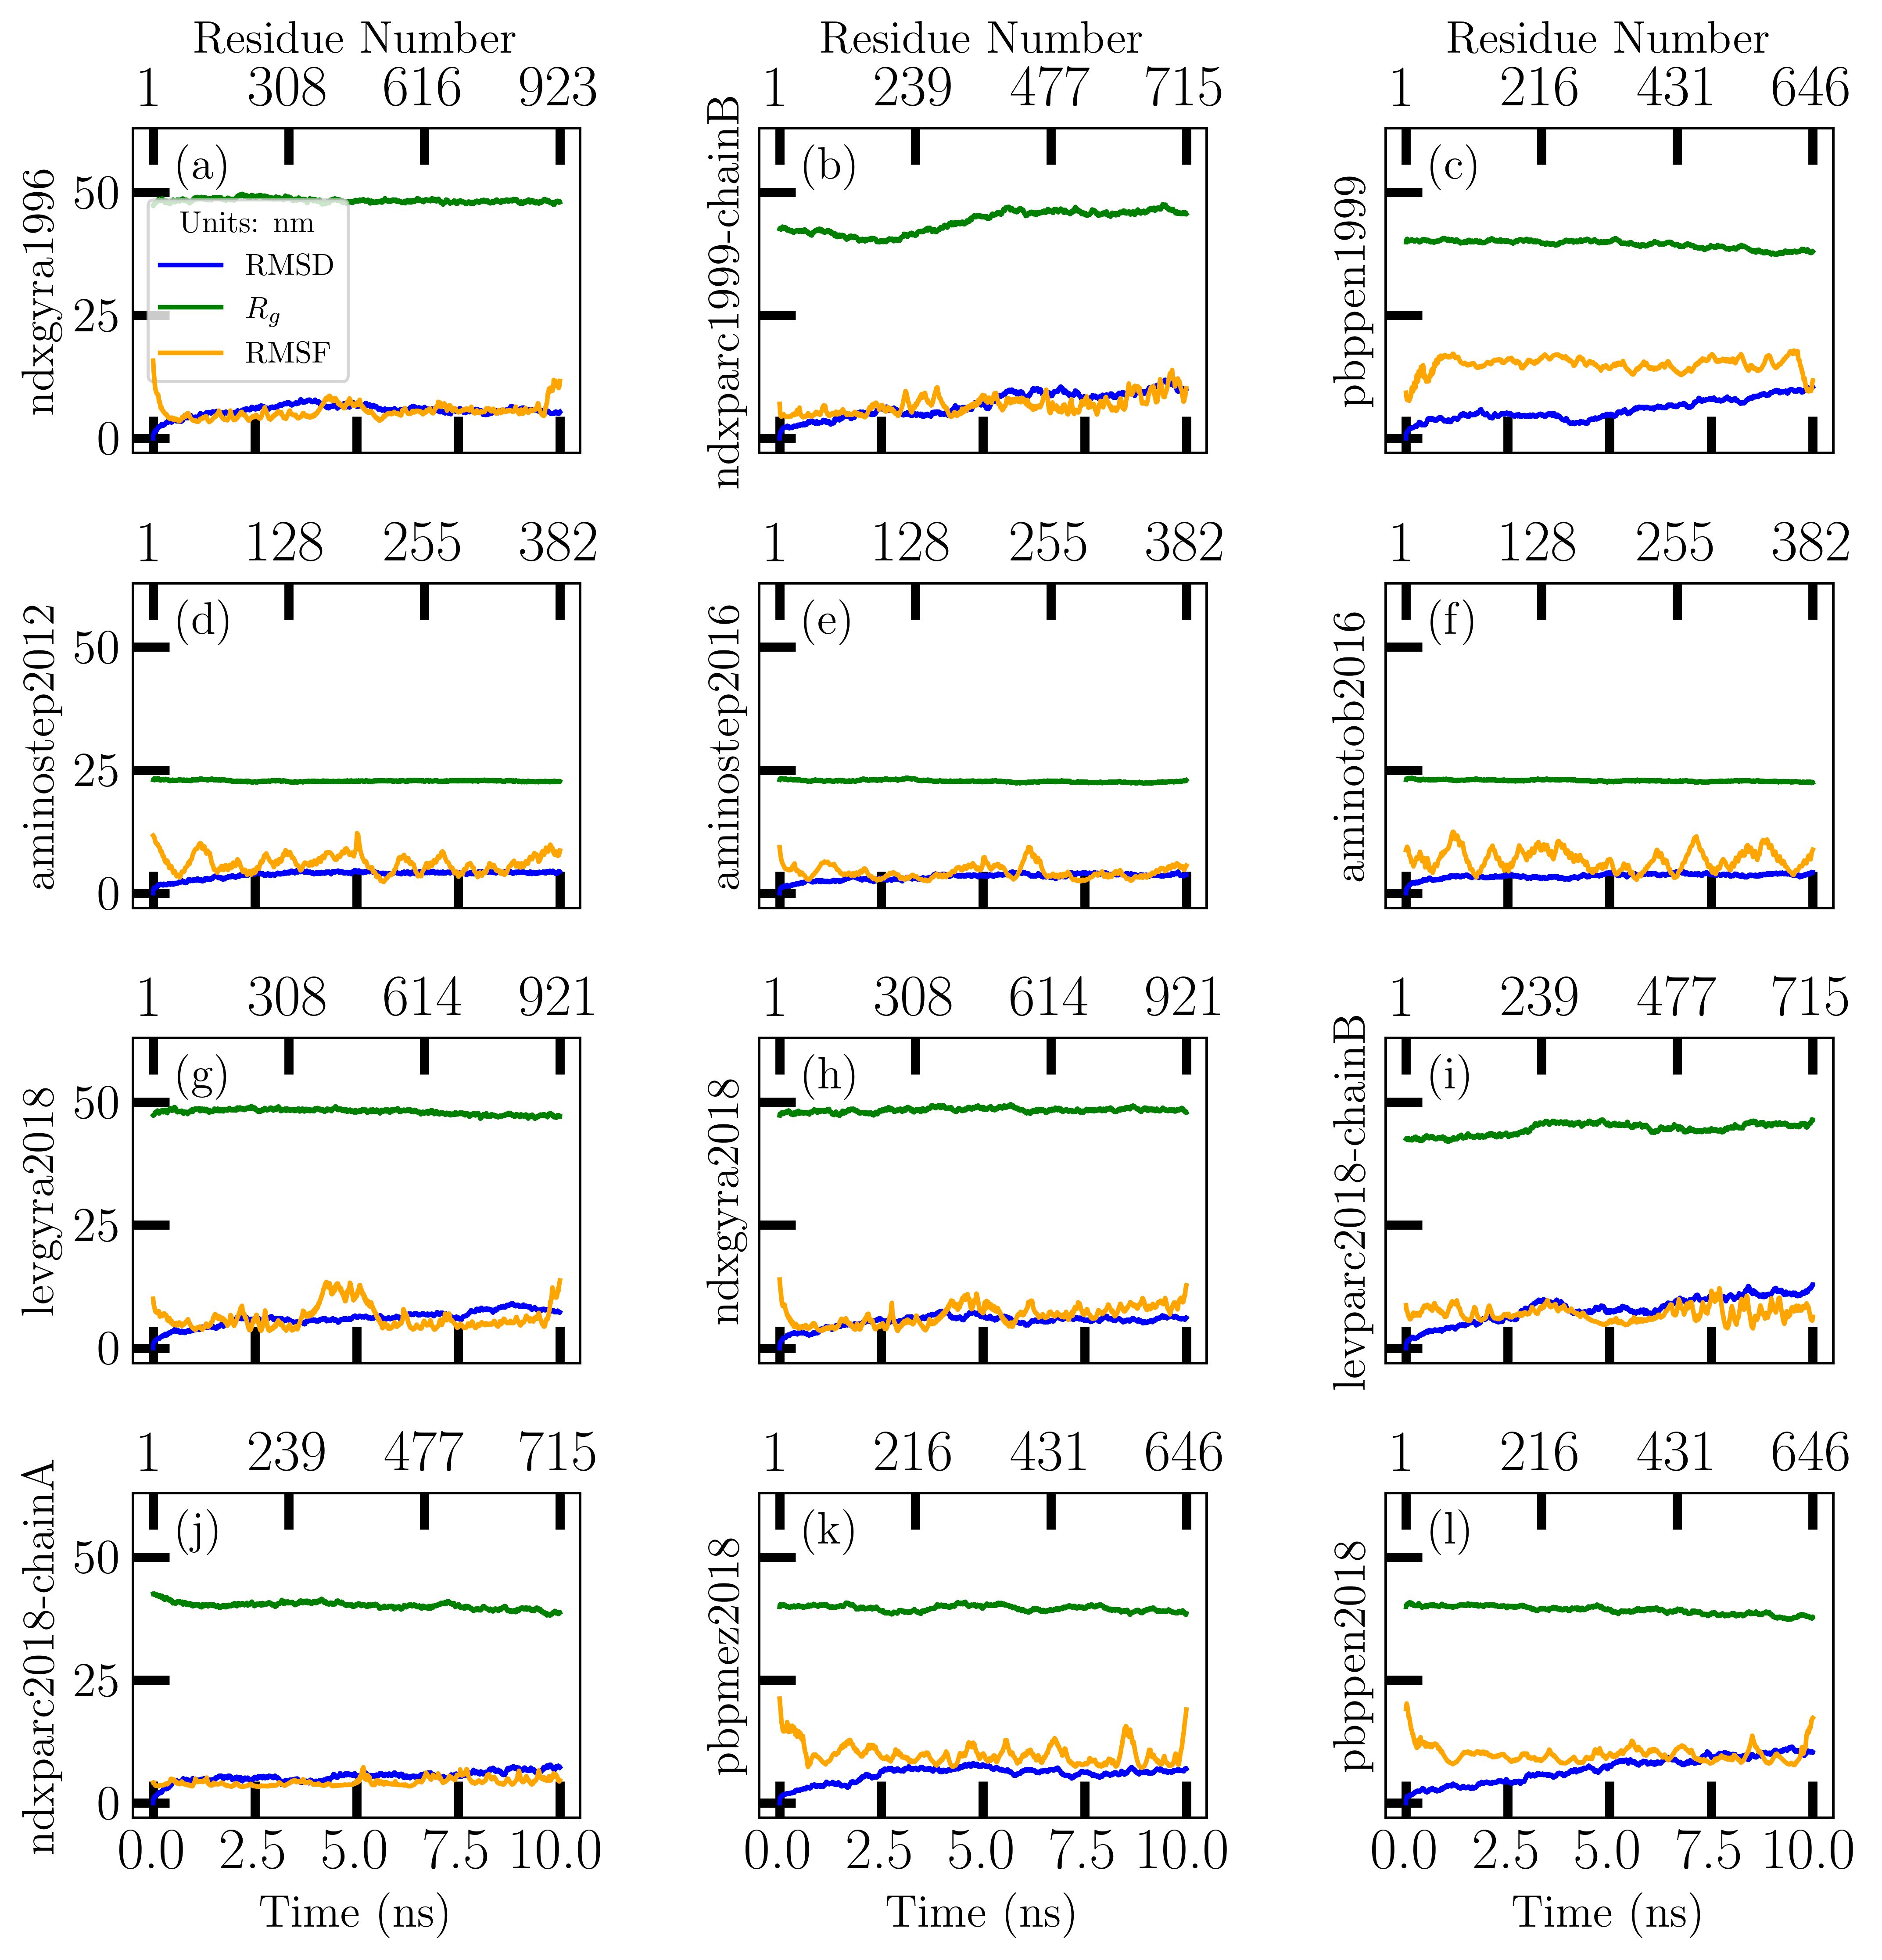

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

matplotlib.rcParams['axes.titlepad'] = 0
# Override the behavior of ax.axis('off') so that calls to turn off axes are ignored.
import matplotlib.axes as maxes
matplotlib.rcParams.update({'font.family': 'Times New Roman'})
_original_axis = maxes.Axes.axis

def new_axis(self, *args, **kwargs):
    if args and args[0] == 'off':
        return self  # Skip turning off the axes
    return _original_axis(self, *args, **kwargs)

maxes.Axes.axis = new_axis

def add_plot(complexname, dataframe, axis, top_dict, legend=False, topxlabel=False, bottomxlabel=False):
    axis.set_ylabel(complexname.replace("C", "").replace('_', '-'), fontsize=15)
    axis.plot(dataframe.index/1000, dataframe[complexname], label="RMSD", color='blue')
    axis.plot(rg_df.index/1000, rg_df[complexname], label=r"$R_g$", color='green')
    axis.set_xticks(dataframe.index[::int(len(dataframe)/4)]/1000)
    axis.set_xticklabels(dataframe.index[::int(len(dataframe)/4)]/1000)
    
    ax_top = axis.twiny()
    
    ax_top.plot(top_dict[f"{complexname}_resid"], top_dict[f"{complexname}_rmsf"], label="RMSF", color='orange')
    ticks = np.linspace(top_dict[f"{complexname}_resid"][0], top_dict[f"{complexname}_resid"][-1], 4)
    ax_top.set_xticks(ticks)
    ax_top.set_xticklabels(["{:.0f}".format(x) for x in ticks])
    if legend:
        lines, labels = axis.get_legend_handles_labels()
        top_lines, top_labels = ax_top.get_legend_handles_labels()
        axis.legend(lines + top_lines, labels + top_labels, loc='best', fontsize=10, title='Units: nm', title_fontsize=10)
    if topxlabel:
        ax_top.set_xlabel('Residue Number', fontsize=15)
    if bottomxlabel:
        axis.set_xlabel('Time (ns)', fontsize=15)    

# Define a 5x3 grid with custom spacing between subplots
fig, axs = plt.subplots(4, 3, figsize=(10, 10), gridspec_kw={'wspace': 0.4, 'hspace': 0.4}, sharex=True, sharey=True)

# Add subplots at specific grid positions
# For example, here we place one subplot per grid cell in a manner that mimics your layout.
ax_ndxgyra1996  = axs[0, 0]
add_plot('ndxgyra1996C', rmsd_df, ax_ndxgyra1996, rmsf_dict, legend=True, topxlabel=True)

ax_ndxparc1999  = axs[0,1]
add_plot('ndxparc1999C_chainB', rmsd_df, ax_ndxparc1999, rmsf_dict, topxlabel=True)

ax_pbppen1999  = axs[0,2]
add_plot('pbppen1999C', rmsd_df, ax_pbppen1999, rmsf_dict, topxlabel=True)

ax_aminostep2012  = axs[1,0]
add_plot('aminostep2012C', rmsd_df, ax_aminostep2012, rmsf_dict)

ax_aminostep2016  = axs[1,1]
add_plot('aminostep2016C', rmsd_df, ax_aminostep2016, rmsf_dict)

ax_aminotob2016  = axs[1,2]
add_plot('aminotob2016C', rmsd_df, ax_aminotob2016, rmsf_dict)


ax_levgyra2018  = axs[2,0]
add_plot('levgyra2018C', rmsd_df, ax_levgyra2018, rmsf_dict)

ax_ndxgyra2018  = axs[2,1]
add_plot('ndxgyra2018C', rmsd_df, ax_ndxgyra2018, rmsf_dict)

ax_levparc2018  = axs[2,2]
add_plot('levparc2018C_chainB', rmsd_df, ax_levparc2018, rmsf_dict)

ax_ndxparc2018  = axs[3,0]
add_plot('ndxparc2018C_chainA', rmsd_df, ax_ndxparc2018, rmsf_dict, bottomxlabel=True)

ax_pbpmez2018  = axs[3,1]
add_plot('pbpmez2018C', rmsd_df, ax_pbpmez2018, rmsf_dict, bottomxlabel=True)


ax_pbppen2018  = axs[3,2]
add_plot('pbppen2018C', rmsd_df, ax_pbppen2018, rmsf_dict, bottomxlabel=True)

labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)', '(j)', '(k)', '(l)']
for ax, label in zip(axs.flatten(), labels):
    ax.text(0.1, 0.95, label, transform=ax.transAxes,
            fontsize=15, fontweight='bold', va='top', ha='left')

for axis in axs.flatten():
    axis.set_ylim(-3, 63)
plt.show()